<a href="https://colab.research.google.com/github/daphnecor/intro-to-rl/blob/main/06_sarsa_in_the_windy_gridworld.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Chapter 6. Temporal-Difference Learning

---

In [1]:
#@title Dependencies
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
from tqdm.notebook import trange, tqdm
from collections import defaultdict

sns.set('notebook', font_scale=1.1, rc={'figure.figsize': (5, 5)})
sns.set_style('ticks', rc={'figure.facecolor': 'none', 'axes.facecolor': 'none'})
%config InlineBackend.figure_format = 'svg'
matplotlib.rcParams['figure.facecolor'] = 'white'

### Example 6.5: Windy Gridworld

We will apply $\varepsilon$-greedy Sarsa to the windy gridworld. 

The Sarsa (on-policy TD control) update rule for estimating $Q \approx q_{*}$ is:

\begin{align*}
    Q(S, A) \leftarrow Q(S, A) + \alpha 
     [R + \gamma Q(S', A') - Q(S, A)]
\end{align*}

Notes
- There is a crosswind running _upward_ through the middle of the grid. This means the resultant next states are shifted upward by "wind" which varies per column (see Figure).
- Rewards are `-1` until the goal is reached.
- We don't use discounting



In [2]:
class WindyWorld:
    """Windy gridworld environment class."""
    def __init__(self, start_state, terminal_state, nrows, ncols):
        self.start_state = start_state
        self.terminal_state = terminal_state
        self.nrows = nrows
        self.ncols = ncols
        self.action_space = [0, 1, 2, 3]
        self._reset()

    def _reset(self):
        """Reset environment to start position."""
        self.x = self.start_state[0]
        self.y = self.start_state[1]
        action = np.random.choice(self.action_space)
        return (self.x, self.y), action, False

    def step(self, action):
        """(state, action) --> (next_state, reward, done)."""
        self.x, self.y = self.apply_action(self.x, self.y, action)

        # Check if we have reached the goal
        if self.x == self.terminal_state[0] and self.y == self.terminal_state[1]:
            return (self.x, self.y), -1, True
        else:
            return (self.x, self.y), -1, False

    def apply_action(self, x, y, action):

        # Apply wind
        if x in [3,4,5,8]:  y += 1    
        if x in [6,7]:      y += 2    
        
        if action == 0:    x -= 1     # Left
        elif action == 1:  y -= 1     # Down
        elif action == 2:  x += 1     # Right
        elif action == 3:  y += 1     # Up

        # Make sure we stay inside our grid world
        x = np.clip(x, 0, self.nrows)  
        y = np.clip(y, 0, self.ncols)  
        
        return (x, y)

In [3]:
# Parameters
alpha = 0.5 # Learning rate
eps = 0.1 # Exploration rate
num_episodes = 170 # Number of episodes
MAX_STEPS = 8000 # Maximum number of allowed steps in each episode
req_steps_to_goal = np.zeros(num_episodes)
steps_in_episode = []
# Create environment
env = WindyWorld(
    nrows=9,
    ncols=6,
    start_state=(0, 3),
    terminal_state=(7, 3),
)

In [4]:
# Loop for each episode
Q = defaultdict(float)
glob_steps = 0

for episode in range(num_episodes):

    # Initialize S and choose random action
    state, action, done = env._reset()
    steps = 0
    while not done: 

        # Take action A, observe R, S'
        next_state, reward, done = env.step(action)

        #print(f"S: {state} | A: {action} | S': {next_state} | R: {reward}")

        # Play random action with probability epsilon (explore)
        if np.random.random() < eps: 
            next_action = np.random.choice(env.action_space)
        
        else: # Exploit
            q_vals_in_state = [Q[state, act] for act in env.action_space]
            next_action = np.random.choice( 
                np.flatnonzero(q_vals_in_state == np.max(q_vals_in_state))
            )
        
        # Update Q-table
        Q[state, action] += alpha * (reward + Q[next_state, next_action] - Q[state, action])

        # S, A = S', A'
        state, action = next_state, next_action

        if done:
            if episode % 20 == 0:
                print(f'Episode: {episode} | Reached goal state in {steps} steps')
            req_steps_to_goal[episode] = steps

        if steps > MAX_STEPS:
            break

        # Increment counter
        steps += 1
        steps_in_episode.append(episode)

Episode: 0 | Reached goal state in 622 steps
Episode: 20 | Reached goal state in 28 steps
Episode: 40 | Reached goal state in 429 steps
Episode: 60 | Reached goal state in 79 steps
Episode: 80 | Reached goal state in 35 steps
Episode: 100 | Reached goal state in 94 steps
Episode: 120 | Reached goal state in 49 steps
Episode: 140 | Reached goal state in 40 steps
Episode: 160 | Reached goal state in 66 steps


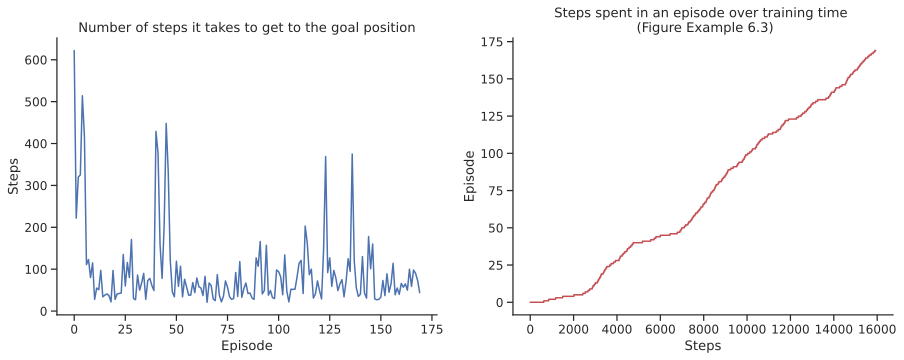

In [9]:
fig, axs = plt.subplots(1, 2, figsize=(15, 5))

axs[0].set_title('Number of steps it takes to get to the goal position')
axs[0].plot(req_steps_to_goal)
axs[0].set_xlabel('Episode')
axs[0].set_ylabel('Steps')

axs[1].set_title('Steps spent in an episode over training time \n (Figure Example 6.3)')
axs[1].plot(steps_in_episode, 'r')
axs[1].set_xlabel('Steps')
axs[1].set_ylabel('Episode')

sns.despine()